In [1]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
temp_cols = ["Temperature (Dry Bulb) - Fahrenheit","Heat Index Temperature - Fahrenheit","Wind Chill Temperature - Fahrenheit"]
dummy_cal_mos = ["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
dummy_he = ["HE%.2d" % h for h in range(2,25)]
seasonal_variables = dummy_cal_mos + dummy_he + ["Weekend","Year"]
weather_vars = ['Temperature (Dry Bulb) - Fahrenheit','Heat Index Temperature - Fahrenheit','Wind Chill Temperature - Fahrenheit']
predictive_load_model = dict()
std_scalar_transform = dict()
lz_ws_mapping = pd.read_hdf(r".\Cleaned Data\lz_ws_mapping.hdf")
load_zones = lz_ws_mapping.columns[1:]

model_trn_scores = pd.DataFrame(index=load_zones,columns=["Training Rsq"])
model_trn_scores.index.name = "Load Zone"

for lz in load_zones:
    df = pd.read_hdf(r".\Cleaned Data\regression_df.hdf",lz)
    
    for t in temp_cols:
        df[t + " Sq"] = df[t]**2.0
    df["Wchill_DryBulb"] = df[temp_cols[0]]*df[temp_cols[2]]
    df["HeatIdx_DryBulb"] = df[temp_cols[0]]*df[temp_cols[1]]
    df["HeatIdx_WChill"] = df[temp_cols[1]]*df[temp_cols[2]]
    
    regression_vars = seasonal_variables + weather_vars[-6:] + ["Wchill_DryBulb","HeatIdx_DryBulb","HeatIdx_WChill"]    
    X = df[regression_vars]
    y = df[lz]
    
#     random_forest_models[lz] = RandomForestRegressor()
#     random_forest_models[lz].fit(X,y)
    
    #Xstd = StandardScaler().fit_transform(X)
    std_scalar_transform[lz] = StandardScaler()
    std_scalar_transform[lz].fit(X)
    Xstd = std_scalar_transform[lz].transform(X)
    
    
    
    predictive_load_model[lz] = GridSearchCV(Ridge(),{"alpha":[10.0],"fit_intercept":[True]},cv=5)
    predictive_load_model[lz].fit(Xstd,y)

    
    model_trn_scores.loc[lz,"Training Rsq"] = predictive_load_model[lz].score(Xstd,y)

In [3]:
model_trn_scores

,Training Rsq
Load Zone,
.Z.CONNECTICUT,0.878762
.Z.MAINE,0.872839
.Z.NEMASSBOST,0.874247
.Z.NEWHAMPSHIRE,0.887788
.Z.RHODEISLAND,0.875297
.Z.SEMASS,0.875888
.Z.VERMONT,0.841051
.Z.WCMASS,0.848376


In [7]:
nws_forecast = pd.read_excel(r".\Cleaned Data\Weather Forecast Update 2018-05-10.xlsx","Import")

st_time = nws_forecast["Local Datetime (Hour Beginning)"].min()
en_time = nws_forecast["Local Datetime (Hour Ending)"].max()
fcast_dtidx = pd.date_range(st_time,en_time,freq="H",closed="left")
fcast_dtidx.name = "Local Datetime (Hour Beginning)"
fcast_df = pd.DataFrame(index=fcast_dtidx)
fcast_temp_df = pd.DataFrame(index=fcast_dtidx)
weather_cols = df.columns[-9:]

for lz in load_zones:
    wstation_wgt = lz_ws_mapping.loc[lz_ws_mapping[lz] > .01,lz]
    agg_temp_df = pd.DataFrame(index=fcast_dtidx,columns=weather_cols,data=0.0,dtype=float)
    agg_temp_df["Weight"] = 0.0

    season_df = pd.DataFrame(index=fcast_dtidx,columns=["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"] + ["HE%.2d" % h for h in range(2,25)],data=0.0)
    season_df["Year"] = season_df.index.year
    season_df["Weekend"] = 0.0
    season_df.loc[season_df.index.dayofweek > 4,"Weekend"] = 1.0
    cmo_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    for i in season_df.index:
        if cmo_dict[i.month] != "Jan":
            season_df.loc[i,cmo_dict[i.month]] = 1.0
        if (i.hour + 1) != 1:
            season_df.loc[i,"HE%.2d" % (i.hour + 1)] = 1.0



    for ws in wstation_wgt.index:
        ws_wgt = wstation_wgt.loc[ws]
        wsdata = nws_forecast.loc[nws_forecast["Weather Station Name"] == ws]
        wsdata = wsdata.rename(columns={"Local Datetime (Hour Beginning)":"Interval"})
        ws_contrib = wsdata.groupby("Interval").mean()[weather_cols]*ws_wgt
        ws_contrib = ws_contrib.join(wsdata.groupby("Interval").first()["Local Datetime (Hour Ending)"])
        ws_contrib = ws_contrib.loc[np.isfinite(ws_contrib[weather_cols]).all(axis=1)]

        for i in ws_contrib.index:
            agg_temp_df.loc[
                (agg_temp_df.index >= i)&(agg_temp_df.index < ws_contrib.loc[i,"Local Datetime (Hour Ending)"])
                ,weather_cols] += ws_contrib.loc[i,weather_cols].values
            agg_temp_df.loc[
                (agg_temp_df.index >= i)&(agg_temp_df.index < ws_contrib.loc[i,"Local Datetime (Hour Ending)"])
                ,"Weight"] += ws_wgt



    w_scale = np.array(agg_temp_df["Weight"].values,dtype=float)
    agg_temp_df = (agg_temp_df[weather_cols].divide(w_scale,axis=0))[weather_cols]
    agg_temp_df = agg_temp_df.loc[np.isfinite(agg_temp_df).all(axis=1)]
    regr_df = season_df.join(agg_temp_df,how="inner")
    Xstd = std_scalar_transform[lz].transform(regr_df[regression_vars])
    fcast_load = pd.Series(index=regr_df.index,data=predictive_load_model[lz].predict(Xstd),name=lz)
    fcast_temp = regr_df["Temperature (Dry Bulb) - Fahrenheit"].copy()
    fcast_temp.name = lz
    fcast_df = fcast_df.join(fcast_load.copy(),how="inner")
    fcast_temp_df = fcast_temp_df.join(fcast_temp.copy(),how="inner")

In [8]:
fcast_df["ISONE"] = fcast_df.sum(axis=1)
fcast_temp_df["ISONE"] = fcast_temp_df[load_zones].mean(axis=1)

In [9]:
import mysql.connector
import sshtunnel

sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='an2683', ssh_password='101Proof',
    remote_bind_address=('an2683.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    connection = mysql.connector.connect(
        user='an2683', password='101Proof',
        host='127.0.0.1', port=tunnel.local_bind_port,
        database='an2683$LOAD_FCAST',
    )
    cursor = connection.cursor()
    add_fcast_row = ("INSERT INTO LoadForecastUpdate "
              "(Date, HE, Zone, Forecast_Demand_MW,Forecast_Temp_DryBulb_F) "
              "VALUES (%(dt)s, %(he)s, %(zone)s, %(mw)s, %(temp)s)")

    for lz in fcast_df.columns:
        for dt in fcast_df.index:
            fcast_row = {
                'dt': (dt.floor("D")).strftime("%Y-%m-%d"),
                'he': dt.hour + 1,
                'zone': lz,
                'mw': float(np.round(fcast_df.loc[dt,lz],1)),
                'temp':float(np.round(fcast_temp_df.loc[dt,lz],1)),              
            }
            print(fcast_row)
            cursor.execute(add_fcast_row,fcast_row)
    connection.commit()
    cursor.close()
    connection.close()
# from mysql.connector import (connection)

# cnx = connection.MySQLConnection(user='an2683', password='101Proof',
#                                  host='an2683.mysql.pythonanywhere-services.com',
#                                  database='an2683$LOAD_FCAST')
# cnx.close()
    

{'zone': '.Z.CONNECTICUT', 'temp': 63.6, 'dt': '2018-05-07', 'he': 17, 'mw': 3092.9}
{'zone': '.Z.CONNECTICUT', 'temp': 63.6, 'dt': '2018-05-07', 'he': 18, 'mw': 3243.2}
{'zone': '.Z.CONNECTICUT', 'temp': 63.6, 'dt': '2018-05-07', 'he': 19, 'mw': 3291.7}
{'zone': '.Z.CONNECTICUT', 'temp': 58.0, 'dt': '2018-05-07', 'he': 20, 'mw': 3107.8}
{'zone': '.Z.CONNECTICUT', 'temp': 58.0, 'dt': '2018-05-07', 'he': 21, 'mw': 3052.8}
{'zone': '.Z.CONNECTICUT', 'temp': 58.0, 'dt': '2018-05-07', 'he': 22, 'mw': 2854.9}
{'zone': '.Z.CONNECTICUT', 'temp': 54.5, 'dt': '2018-05-07', 'he': 23, 'mw': 2404.9}
{'zone': '.Z.CONNECTICUT', 'temp': 54.5, 'dt': '2018-05-07', 'he': 24, 'mw': 2085.0}
{'zone': '.Z.CONNECTICUT', 'temp': 54.5, 'dt': '2018-05-08', 'he': 1, 'mw': 1852.4}
{'zone': '.Z.CONNECTICUT', 'temp': 52.4, 'dt': '2018-05-08', 'he': 2, 'mw': 1500.0}
{'zone': '.Z.CONNECTICUT', 'temp': 52.4, 'dt': '2018-05-08', 'he': 3, 'mw': 1425.2}
{'zone': '.Z.CONNECTICUT', 'temp': 52.4, 'dt': '2018-05-08', 'he': 4

In [4]:
import mysql.connector
import sshtunnel

sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='an2683', ssh_password='101Proof',
    remote_bind_address=('an2683.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    connection = mysql.connector.connect(
        user='an2683', password='101Proof',
        host='127.0.0.1', port=tunnel.local_bind_port,
        database='an2683$LOAD_FCAST',
    )
    cursor = connection.cursor()
    delete_fcast_row = "Delete From LoadForecastUpdate;"

    cursor.execute(delete_fcast_row)
    connection.commit()
    cursor.close()
    connection.close()

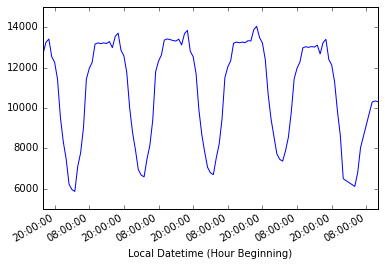

In [66]:
fcast_temp_df

,.Z.CONNECTICUT,.Z.MAINE,.Z.NEMASSBOST,.Z.NEWHAMPSHIRE,.Z.RHODEISLAND,.Z.SEMASS,.Z.VERMONT,.Z.WCMASS,ISONE
Local Datetime (Hour Beginning),,,,,,,,,
2018-05-07 16:00:00,63.647485,59.708258,58.801942,61.939905,61.501808,59.912981,62.712949,64.268446,61.561722
2018-05-07 17:00:00,63.647485,59.708258,58.801942,61.939905,61.501808,59.912981,62.712949,64.268446,61.561722
2018-05-07 18:00:00,63.647485,59.708258,58.801942,61.939905,61.501808,59.912981,62.712949,64.268446,61.561722
2018-05-07 19:00:00,58.000000,50.610509,54.192929,54.065592,56.246514,56.743196,54.544631,55.508075,54.988931
2018-05-07 20:00:00,58.000000,50.610509,54.192929,54.065592,56.246514,56.743196,54.544631,55.508075,54.988931
2018-05-07 21:00:00,58.000000,50.610509,54.192929,54.065592,56.246514,56.743196,54.544631,55.508075,54.988931
2018-05-07 22:00:00,54.495782,45.854545,50.943826,49.628435,52.597211,54.378645,50.254617,51.275426,51.178561
2018-05-07 23:00:00,54.495782,45.854545,50.943826,49.628435,52.597211,54.378645,50.254617,51.275426,51.178561
2018-05-08 00:00:00,54.495782,45.854545,50.943826,49.628435,52.597211,54.378645,50.254617,51.275426,51.178561
